In [101]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from fredapi import Fred

# Define the list of tickers and their corresponding yfinance symbols or FRED series IDs
tickers = {
    "S&P 500": "^GSPC",
    "Dow Jones Industrial Average": "^DJI",
    "NASDAQ Composite Index": "^IXIC",
    "Russell 2000 Index": "^RUT",
    "MSCI World Index": "URTH",
    "FTSE 100": "^FTSE",
    "Nikkei 225": "^N225",
    "Hang Seng Index": "^HSI",
    "Shanghai Composite Index": "000001.SS",
    "Euro Stoxx 50": "^STOXX50E",
    "DAX Index": "^GDAXI",
    "CAC 40": "^FCHI",
    "S&P/ASX 200": "^AXJO",
    "BSE Sensex": "^BSESN",
    "Nifty 50": "^NSEI",
    "US 10Y Treasury Yield": "DGS10",
    "US 2Y Treasury Yield": "DGS2",
    "Federal Funds Rate": "DFF",
    "Dollar Index": "DTWEXBGS",
    "EUR/USD Exchange Rate": "DEXUSEU",
    "USD/JPY Exchange Rate": "DEXJPUS",
    "GBP/USD Exchange Rate": "DEXUSUK",
    "USD/CNY Exchange Rate": "DEXCHUS"
}

# Define the start and end dates
start_date = "2019-01-01"
end_date = "2023-12-31"

# Adjust the start date to ensure the interpolation window
start_date_adjusted = (datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=7)).strftime('%Y-%m-%d')

fred = Fred(api_key='ec0293b2fb9d336968dfd854c381389a')

# Function to get data from yfinance
def get_yfinance_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    data = data[['Close']]
    return data

# Function to get data from FRED
def get_fred_data(ticker, start, end):
    data = fred.get_series(ticker, start, end)
    return pd.DataFrame(data, columns=[ticker])

# Initialize an empty dictionary to hold dataframes
data_frames = {}

# Fetch data for each ticker
for name, ticker in tickers.items():
    try:
        if ticker:
            if ticker.startswith('D') or ticker in ['USD3MTD156N', 'DFF', 'CPIAUCSL', 'PPIACO', 'UNRATE', 'A191RL1Q225SBEA']:
                data_frames[name] = get_fred_data(ticker, start_date, end_date)
            else:
                data_frames[name] = get_yfinance_data(ticker, start_date, end_date)
        else:
            print(f"No valid ticker for {name}")
    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")

# Function to calculate 7-day change, volatility, and store interpolated values
def calculate_change_and_volatility(df):
    results = []
    df_interpolated = df.interpolate(method='linear')

    for i in range(len(df_interpolated) - 7):
        window = df_interpolated.iloc[i:i+8].copy()

        start_value = window.iloc[0]
        end_value = window.iloc[-1]
        change = end_value - start_value
        volatility = window.max() - window.min()

        # Determine if the value was interpolated or original
        original_value = df.iloc[i].values[0]
        interpolated_value = df_interpolated.iloc[i].values[0]
        value = interpolated_value if pd.isnull(original_value) else original_value

        results.append({
            'date': df.index[i],
            'value': value,
            '7_day_change': change.values[0],
            '7_day_volatility': volatility.values[0]
        })

    return pd.DataFrame(results)

# Create a dictionary to hold the results
change_volatility_frames = {}

# Calculate change and volatility for each dataframe
for name, df in data_frames.items():
    print(f"Processing {name}")
    change_volatility_frames[name] = calculate_change_and_volatility(df)

# Example of accessing the data
for name, df in change_volatility_frames.items():
    print(f"{name} change and volatility data:")
    print(df.head())

# Save each dataframe to a separate CSV file (optional)
for name, df in change_volatility_frames.items():
    safe_name = name.replace(' ', '_').replace('&', 'and').replace('/', '_')
    try:
        df.to_csv(f"/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/거시경제/{safe_name}_change_volatility.csv", index=False)
    except Exception as e:
        print(f"Error saving {name} data: {e}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Processing S&P 500
Processing Dow Jones Industrial Average
Processing NASDAQ Composite Index
Processing Russell 2000 Index
Processing MSCI World Index
Processing FTSE 100
Processing Nikkei 225
Processing Hang Seng Index
Processing Shanghai Composite Index
Processing Euro Stoxx 50
Processing DAX Index
Processing CAC 40
Processing S&P/ASX 200
Processing BSE Sensex
Processing Nifty 50
Processing US 10Y Treasury Yield
Processing US 2Y Treasury Yield
Processing Federal Funds Rate
Processing Dollar Index
Processing EUR/USD Exchange Rate
Processing USD/JPY Exchange Rate
Processing GBP/USD Exchange Rate
Processing USD/CNY Exchange Rate
S&P 500 change and volatility data:
        date        value  7_day_change  7_day_volatility
0 2019-01-02  2510.030029     86.229980        148.750000
1 2019-01-03  2447.889893    134.720215        148.750000
2 2019-01-04  2531.939941     78.360107         78.360107
3 2019-01-07  2549.689941     66.410156         66.410156
4 2019-01-08  2574.409912     61.55004

### Step 2. ETF 가격 예측

In [102]:
import os

# ETF 목록
etf_list = [
    "XLK", "VGT", "XLF", "VFH", "XLV", "VHT", "XLE", "VDE",
    "XLI", "VIS", "XLY", "VCR", "XLP", "VDC", "XLC", "VOX",
    "XLU", "VPU", "XLRE", "VNQ", "BND", "AGG", "LQD", "HYG",
    "IEF", "GLD", "IAU", "SLV", "USO", "DBO", "VNQ", "REET",
    "IYR", "UUP", "FXE", "FXY", "FXB", "FXC"
]

# 데이터 저장 경로
save_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector"

# 폴더가 존재하지 않으면 생성
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 시작일과 종료일 설정
start_date = "2013-01-01"
end_date = "2023-12-31"

# 각 ETF의 데이터를 다운로드하고 저장
for etf in etf_list:
    data = yf.download(etf, start=start_date, end=end_date)
    df = data[['Close']].reset_index()
    df.columns = ['Date', 'Close']  # 칼럼 이름 재설정
    
    file_path = os.path.join(save_path, f"{etf}_price_data.csv")
    df.to_csv(file_path, index=False)
    print(f"{etf} 데이터 저장 완료: {file_path}")

[*********************100%%**********************]  1 of 1 completed


XLK 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLK_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VGT 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VGT_price_data.csv


[*********************100%%**********************]  1 of 1 completed


XLF 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLF_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VFH 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VFH_price_data.csv


[*********************100%%**********************]  1 of 1 completed


XLV 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLV_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VHT 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VHT_price_data.csv


[*********************100%%**********************]  1 of 1 completed


XLE 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLE_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VDE 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VDE_price_data.csv


[*********************100%%**********************]  1 of 1 completed


XLI 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLI_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VIS 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VIS_price_data.csv


[*********************100%%**********************]  1 of 1 completed


XLY 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLY_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VCR 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VCR_price_data.csv


[*********************100%%**********************]  1 of 1 completed


XLP 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLP_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VDC 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VDC_price_data.csv


[*********************100%%**********************]  1 of 1 completed


XLC 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLC_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VOX 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VOX_price_data.csv


[*********************100%%**********************]  1 of 1 completed


XLU 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLU_price_data.csv


[*********************100%%**********************]  1 of 1 completed


VPU 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VPU_price_data.csv


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


XLRE 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLRE_price_data.csv
VNQ 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VNQ_price_data.csv


[*********************100%%**********************]  1 of 1 completed


BND 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/BND_price_data.csv


[*********************100%%**********************]  1 of 1 completed


AGG 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/AGG_price_data.csv


[*********************100%%**********************]  1 of 1 completed


LQD 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/LQD_price_data.csv


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


HYG 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/HYG_price_data.csv
IEF 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/IEF_price_data.csv
GLD 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/GLD_price_data.csv
IAU 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/IAU_price_data.csv
SLV 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/SLV_price_data.csv
USO 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/USO_price_data.csv
DBO 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

REET 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/REET_price_data.csv
IYR 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/IYR_price_data.csv
UUP 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/UUP_price_data.csv
FXE 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/FXE_price_data.csv
FXY 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/FXY_price_data.csv
FXB 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/FXB_price_data.csv
FXC 데이터 저장 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capsto

In [104]:
save_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector"

# ETF 목록
etf_list = [
    "XLK", "VGT", "XLF", "VFH", "XLV", "VHT", "XLE", "VDE",
    "XLI", "VIS", "XLY", "VCR", "XLP", "VDC", "XLC", "VOX",
    "XLU", "VPU", "XLRE", "VNQ", "BND", "AGG", "LQD", "HYG",
    "IEF", "GLD", "IAU", "SLV", "USO", "DBO", "VNQ", "REET",
    "IYR", "UUP", "FXE", "FXY", "FXB", "FXC"
]

for etf in etf_list:
    file_path = os.path.join(save_path, f"{etf}_price_data.csv")
    df = pd.read_csv(file_path)
    
    # 'Date' 컬럼을 datetime 형식으로 변환
    df['Date'] = pd.to_datetime(df['Date'])
    
    # 7일 후의 날짜 계산
    df['Date_After_7_Days'] = df['Date'] + pd.Timedelta(days=7)
    
    # 7일 후의 가격을 가져오기 위해 merge 수행
    df_merged = pd.merge(df, df[['Date', 'Close']], left_on='Date_After_7_Days', right_on='Date', suffixes=('', '_After_7_Days'))
    
    # 7일 후 가격의 비율 계산
    df_merged['7_Day_Percent_Change'] = ((df_merged['Close_After_7_Days'] / df_merged['Close']) - 1) * 100
    
    # 필요한 컬럼만 유지
    df_final = df_merged[['Date', 'Close', '7_Day_Percent_Change']]
    
    # 다시 저장
    df_final.to_csv(file_path, index=False)
    print(f"{etf} 데이터 업데이트 완료: {file_path}")

XLK 데이터 업데이트 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLK_price_data.csv
VGT 데이터 업데이트 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VGT_price_data.csv
XLF 데이터 업데이트 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLF_price_data.csv
VFH 데이터 업데이트 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VFH_price_data.csv
XLV 데이터 업데이트 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/XLV_price_data.csv
VHT 데이터 업데이트 완료: /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/VHT_price_data.csv
XLE 데이터 업데이트 완료: /Users/stancho/Documents/SogangUniversity/2024s

In [105]:
all_data = {}

# Load the macroeconomic factors data
macro_factors_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/거시경제/"
for name in tickers.keys():
    safe_name = name.replace(' ', '_').replace('&', 'and').replace('/', '_')
    file_path = os.path.join(macro_factors_path, f"{safe_name}_change_volatility.csv")
    try:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['date'])
        df = df[['Date', '7_day_change', '7_day_volatility']]
        all_data[safe_name] = df
    except Exception as e:
        print(f"Error loading macroeconomic factor data for {name}: {e}")

# Load the ETF data
sector_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/sector/"
for etf in etf_list:
    file_path = os.path.join(sector_path, f"{etf}_price_data.csv")
    try:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', '7_Day_Percent_Change']]
        all_data[etf] = df
    except Exception as e:
        print(f"Error loading ETF data for {etf}: {e}")

# Merge all dataframes on the 'Date' column
merged_df = pd.DataFrame({'Date': pd.date_range(start=start_date, end=end_date)})

for name, df in all_data.items():
    merged_df = pd.merge(merged_df, df, on='Date', how='left', suffixes=('', f'_{name}'))

# Drop rows with any missing values
merged_df = merged_df.dropna()

# Display the first few rows of the merged dataframe
print(merged_df.head())

# Save the merged dataframe to a CSV file
output_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/merged_data.csv"
try:
    merged_df.to_csv(output_path, index=False)
    print(f"Merged data saved to {output_path}")
    print(merged_df.head())
except Exception as e:
    print(f"Error saving merged data: {e}")

           Date  7_day_change  7_day_volatility  \
2194 2019-01-04     78.360107         78.360107   
2198 2019-01-08     61.550049         61.550049   
2199 2019-01-09     85.750000         88.099854   
2200 2019-01-10     36.260010         88.099854   
2201 2019-01-11     42.439941         88.099854   

      7_day_change_Dow_Jones_Industrial_Average  \
2194                                 632.429688   
2198                                 582.650391   
2199                                 827.230469   
2200                                 402.560547   
2201                                 579.669922   

      7_day_volatility_Dow_Jones_Industrial_Average  \
2194                                     632.429688   
2198                                     582.650391   
2199                                     827.230469   
2200                                     796.509766   
2201                                     796.509766   

      7_day_change_NASDAQ_Composite_Index  \
2194      

In [106]:
merged_df

,Date,7_day_change,7_day_volatility,7_day_change_Dow_Jones_Industrial_Average,7_day_volatility_Dow_Jones_Industrial_Average,7_day_change_NASDAQ_Composite_Index,7_day_volatility_NASDAQ_Composite_Index,7_day_change_Russell_2000_Index,7_day_volatility_Russell_2000_Index,7_day_change_MSCI_World_Index,...,7_Day_Percent_Change_SLV,7_Day_Percent_Change_USO,7_Day_Percent_Change_DBO,7_Day_Percent_Change_REET,7_Day_Percent_Change_IYR,7_Day_Percent_Change_UUP,7_Day_Percent_Change_FXE,7_Day_Percent_Change_FXY,7_Day_Percent_Change_FXB,7_Day_Percent_Change_FXC
2194,2019-01-04,78.360107,78.360107,632.429688,632.429688,284.970215,284.970215,64.469971,66.630005,2.290001,...,-0.610993,7.072685,6.958472,3.934012,4.491819,-0.392767,0.541629,-0.090860,0.825513,0.868974
2198,2019-01-08,61.550049,61.550049,582.650391,582.650391,187.459961,187.459961,40.699951,40.699951,1.799995,...,-0.612656,4.761905,4.461380,1.654258,2.281617,0.078649,-0.237851,0.056942,1.264487,0.026903
2199,2019-01-09,85.750000,88.099854,827.230469,827.230469,200.149902,251.310059,43.689941,49.689941,2.150002,...,-1.014882,0.090500,0.000000,2.521698,3.054836,1.151247,-1.440090,-0.904878,0.644488,-0.294671
2200,2019-01-10,36.260010,88.099854,402.560547,796.509766,34.290039,251.310059,12.019897,49.689941,0.629997,...,-0.205484,-0.630636,-0.515988,1.512677,2.189025,0.552484,-0.982803,-0.738051,1.917478,-0.241644
2201,2019-01-11,42.439941,88.099854,579.669922,796.509766,54.290039,251.310059,6.880005,49.689941,1.060005,...,-1.844265,3.761475,3.777551,1.587299,2.219945,0.788639,-0.858286,-1.091280,0.168566,0.053844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,2023-12-08,164.000000,164.000000,1310.050781,1310.050781,599.250000,599.250000,140.130005,140.130005,4.559998,...,3.459713,0.931915,1.849312,5.460900,5.585815,-1.255937,1.258305,1.953742,1.044085,1.667599
3997,2023-12-12,103.049805,124.669922,826.410156,979.980469,430.469727,469.819336,135.790039,139.679932,2.410004,...,5.710175,7.953308,1.955312,5.354817,5.811668,-7.477909,1.705283,1.034483,1.232830,1.959144
3998,2023-12-13,47.540039,70.020020,295.730469,475.921875,259.009766,269.259766,86.449951,86.449951,0.759995,...,1.240241,5.296187,-0.961541,-0.504197,-0.167077,-6.273568,0.467570,-0.723190,0.181199,1.007307
3999,2023-12-14,55.200195,76.399902,296.976562,475.921875,313.010742,313.010742,58.679932,76.769897,0.619995,...,0.722347,2.784388,-3.357958,-2.605861,-1.929329,-6.020761,0.137911,-0.381796,-0.594217,0.972868


In [57]:
import pandas as pd
import requests
import zipfile
import os
import glob
from datetime import datetime, timedelta

# Function to download and extract GDELT data
def download_gdelt_data(date):
    url = f"http://data.gdeltproject.org/events/{date}.export.CSV.zip"
    local_zip_file = f"./gdelt/{date}.zip"
    response = requests.get(url, stream=True)
    with open(local_zip_file, 'wb') as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)
    with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
        zip_ref.extractall(f"./gdelt/{date}")
    print(f"Downloaded and extracted data for date: {date}")

# Create a list of dates for processing (last 10 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 10)
dates = pd.date_range(start=start_date, end=end_date, freq='D').strftime('%Y%m%d').tolist()

# Create directories if they do not exist
if not os.path.exists('./gdelt'):
    os.makedirs('./gdelt')

all_data = []
for date in dates:
    try:
        download_gdelt_data(date)
        files = glob.glob(f"./gdelt/{date}/*.CSV")
        for file_path in files:
            print(f"Processing file: {file_path}")
            try:
                df = pd.read_csv(file_path, sep='\t', header=None, dtype=str, usecols=[1, 4, 26])  # Adjust columns as necessary
                df.columns = ['Date', 'URL', 'Title']

                # Select top 30 rows based on some importance metric if available
                # For now, just select the first 30 rows
                df = df.head(30)

                # Keep only 'Date' and 'Title' columns
                df = df[['Date', 'Title']]
                
                all_data.append(df)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    except Exception as e:
        print(f"Error processing date {date}: {e}")

# Concatenate all data into one DataFrame
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    print(f"Sample of the data collected:\n{final_df.head()}")

    # Save the results to a CSV file
    save_path = "./top_30_news_titles_10_years.csv"
    final_df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")
else:
    print("No data was processed.")


Downloaded and extracted data for date: 20240506
Processing file: ./gdelt/20240506/20240506.export.CSV
Downloaded and extracted data for date: 20240507
Processing file: ./gdelt/20240507/20240507.export.CSV
Downloaded and extracted data for date: 20240508
Processing file: ./gdelt/20240508/20240508.export.CSV
Downloaded and extracted data for date: 20240509
Processing file: ./gdelt/20240509/20240509.export.CSV
Downloaded and extracted data for date: 20240510
Processing file: ./gdelt/20240510/20240510.export.CSV
Downloaded and extracted data for date: 20240511
Processing file: ./gdelt/20240511/20240511.export.CSV
Downloaded and extracted data for date: 20240512
Processing file: ./gdelt/20240512/20240512.export.CSV
Downloaded and extracted data for date: 20240513
Processing file: ./gdelt/20240513/20240513.export.CSV
Downloaded and extracted data for date: 20240514
Processing file: ./gdelt/20240514/20240514.export.CSV
Downloaded and extracted data for date: 20240515
Processing file: ./gdelt

Epoch 1/10000


/Users/stancho/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3271 - val_loss: 1.8382
Epoch 2/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4158 - val_loss: 1.7926
Epoch 3/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2589 - val_loss: 1.7571
Epoch 4/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2572 - val_loss: 1.7292
Epoch 5/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1353 - val_loss: 1.7035
Epoch 6/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1856 - val_loss: 1.6848
Epoch 7/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0607 - val_loss: 1.6694
Epoch 8/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1100 - val_loss: 1.6565
Epoch 9/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2015 - val_loss: 1.6410
Epoch 10/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3535 - val_loss: 1.6281
Epoch 11/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1937 - val_loss: 1.6157
Epoch 12/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4858 - val_loss: 1.3120
Epoch 69/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5448 - val_loss: 1.3101
Epoch 70/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5654 - val_loss: 1.3077
Epoch 71/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4957 - val_loss: 1.3046
Epoch 72/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5156 - val_loss: 1.3018
Epoch 73/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5982 - val_loss: 1.2986
Epoch 74/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4236 - val_loss: 1.2947
Epoch 75/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4693 - val_loss: 1.2919
Epoch 76/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5205 - val_loss: 1.2884
Epoch 77/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4803 - val_loss: 1.2864
Epoch 78/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3998 - val_loss: 1.2847
Epoch 79/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

Epoch 135/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2114 - val_loss: 1.1374
Epoch 136/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2392 - val_loss: 1.1366
Epoch 137/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2386 - val_loss: 1.1337
Epoch 138/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2694 - val_loss: 1.1324
Epoch 139/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2740 - val_loss: 1.1290
Epoch 140/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1836 - val_loss: 1.1264
Epoch 141/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1717 - val_loss: 1.1240
Epoch 142/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2337 - val_loss: 1.1245
Epoch 143/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1749 - val_loss: 1.1209
Epoch 144/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2989 - val_loss: 1.1165
Epoch 145/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2865 - val_loss: 1.1145
Epoch 146/10000
24/24

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0479 - val_loss: 1.0015
Epoch 202/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0270 - val_loss: 1.0007
Epoch 203/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1220 - val_loss: 0.9980
Epoch 204/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9601 - val_loss: 0.9967
Epoch 205/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1265 - val_loss: 0.9963
Epoch 206/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0162 - val_loss: 0.9920
Epoch 207/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9591 - val_loss: 0.9904
Epoch 208/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0227 - val_loss: 0.9912
Epoch 209/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0406 - val_loss: 0.9900
Epoch 210/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0044 - val_loss: 0.9861
Epoch 211/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0129 - val_loss: 0.9849
Epoch 212/10000
24/24 ━━━━━━━━━━━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0001 - val_loss: 0.9040
Epoch 268/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9051 - val_loss: 0.8999
Epoch 269/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9067 - val_loss: 0.8996
Epoch 270/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9184 - val_loss: 0.8974
Epoch 271/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8959 - val_loss: 0.8956
Epoch 272/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9199 - val_loss: 0.8988
Epoch 273/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8695 - val_loss: 0.8939
Epoch 274/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9221 - val_loss: 0.8900
Epoch 275/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9018 - val_loss: 0.8907
Epoch 276/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0362 - val_loss: 0.8864
Epoch 277/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8916 - val_loss: 0.8882
Epoch 278/10000
24/24 ━━━━━━━━━━━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8028 - val_loss: 0.8228
Epoch 334/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8332 - val_loss: 0.8184
Epoch 335/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8776 - val_loss: 0.8186
Epoch 336/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8560 - val_loss: 0.8175
Epoch 337/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8962 - val_loss: 0.8167
Epoch 338/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8075 - val_loss: 0.8145
Epoch 339/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8434 - val_loss: 0.8168
Epoch 340/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8267 - val_loss: 0.8136
Epoch 341/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7970 - val_loss: 0.8113
Epoch 342/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8264 - val_loss: 0.8158
Epoch 343/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7914 - val_loss: 0.8129
Epoch 344/10000
24/24 ━━━━━━━━━━━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8084 - val_loss: 0.7610
Epoch 400/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7859 - val_loss: 0.7626
Epoch 401/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8074 - val_loss: 0.7607
Epoch 402/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7288 - val_loss: 0.7620
Epoch 403/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7574 - val_loss: 0.7643
Epoch 404/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7693 - val_loss: 0.7663
Epoch 405/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7646 - val_loss: 0.7610
Epoch 406/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8369 - val_loss: 0.7588
Epoch 407/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7169 - val_loss: 0.7585
Epoch 408/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8068 - val_loss: 0.7556
Epoch 409/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7678 - val_loss: 0.7561
Epoch 410/10000
24/24 ━━━━━━━━━━━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6845 - val_loss: 0.7143
Epoch 466/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7829 - val_loss: 0.7162
Epoch 467/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7046 - val_loss: 0.7130
Epoch 468/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7007 - val_loss: 0.7121
Epoch 469/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8076 - val_loss: 0.7125
Epoch 470/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7140 - val_loss: 0.7107
Epoch 471/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7319 - val_loss: 0.7119
Epoch 472/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7327 - val_loss: 0.7094
Epoch 473/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7473 - val_loss: 0.7116
Epoch 474/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - val_loss: 0.7077
Epoch 475/10000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6679 - val_loss: 0.7157
Epoch 476/10000
24/24 ━━━━━━━━━━━━━━━

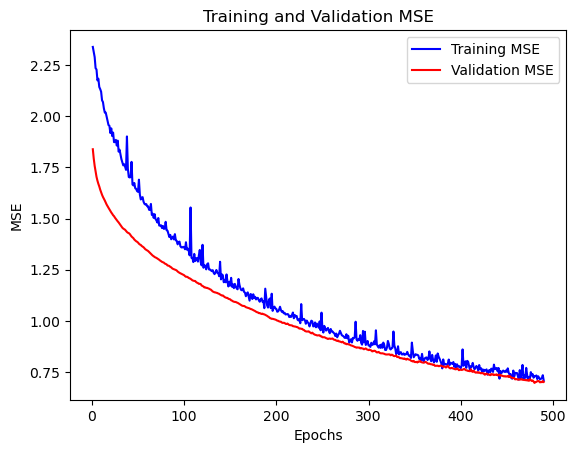

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Test RMSE: 2.4985367019718745
Model saved to /Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/deep_learning_model.h5


In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

# Load the merged dataset
merged_data_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/merged_data.csv"
merged_df = pd.read_csv(merged_data_path)

# Define the input and output columns
input_columns = [col for col in merged_df.columns if '7_day_change' in col or '7_day_volatility' in col]
output_columns = [col for col in merged_df.columns if '7_Day_Percent_Change' in col]

# Drop the date column
merged_df = merged_df.drop(columns=['Date'])

# Split the data into input (X) and output (y)
X = merged_df[input_columns]
y = merged_df[output_columns]

# Standardize the input features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Standardize the output features
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the optimizer
optimizer = Adam(learning_rate=0.0001)

# Define the model architecture with more hidden layers and dropout
model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(y_train.shape[1])  # Output layer with the number of outputs matching y_train
])

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Plot MSE for each epoch
train_mse = history.history['loss']
val_mse = history.history['val_loss']
epochs = range(1, len(train_mse) + 1)

plt.plot(epochs, train_mse, 'b', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_predictions = scaler_y.inverse_transform(test_predictions)  # Rescale predictions
y_test_rescaled = scaler_y.inverse_transform(y_test)  # Rescale true values

mse_test = mean_squared_error(y_test_rescaled, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test RMSE: {rmse_test}')

# Save the model
model_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/deep_learning_model.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


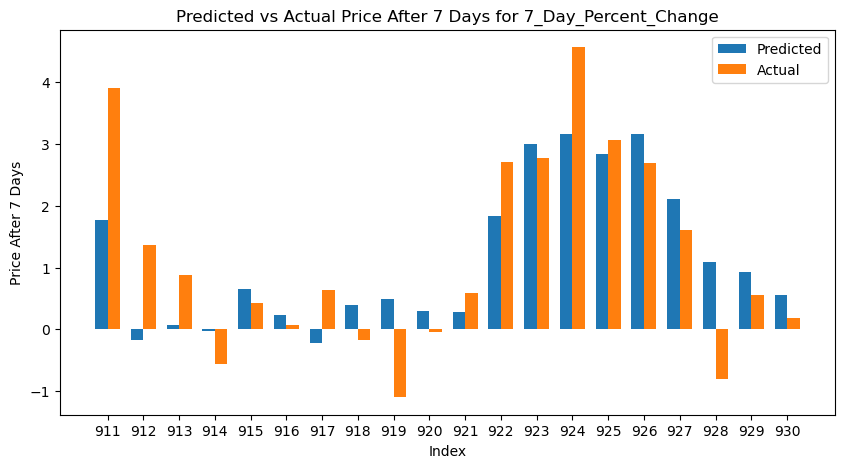

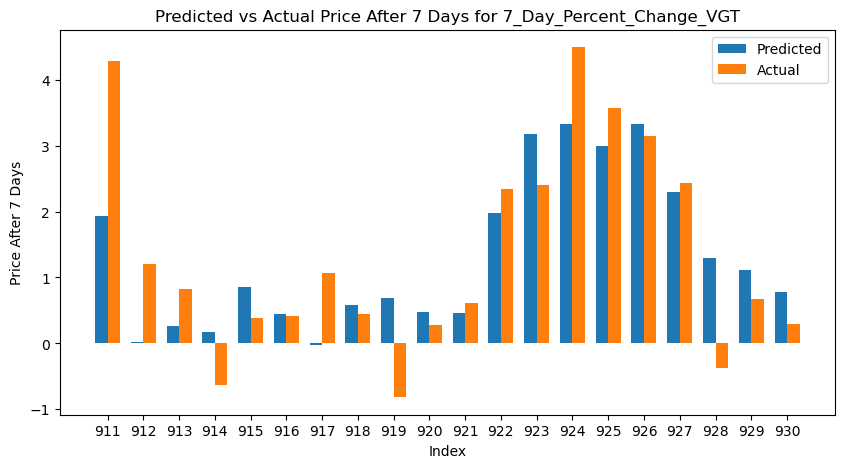

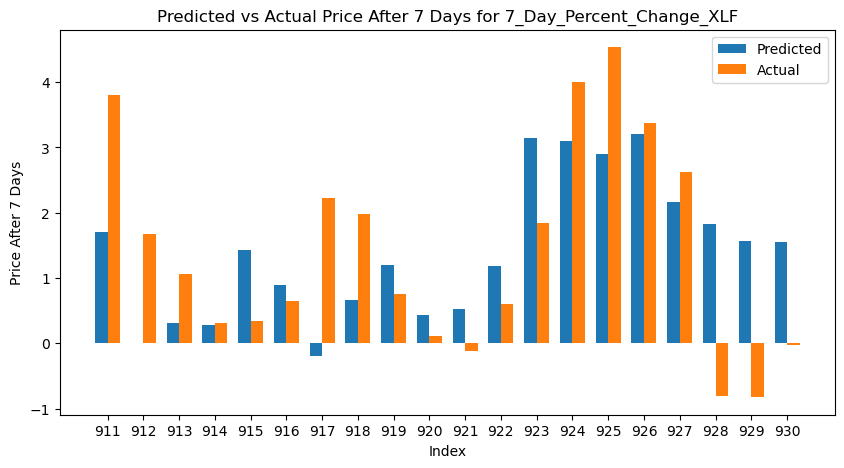

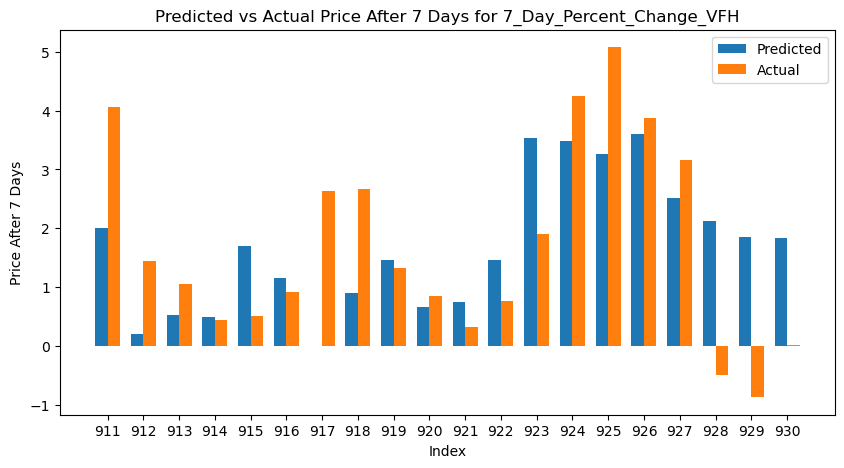

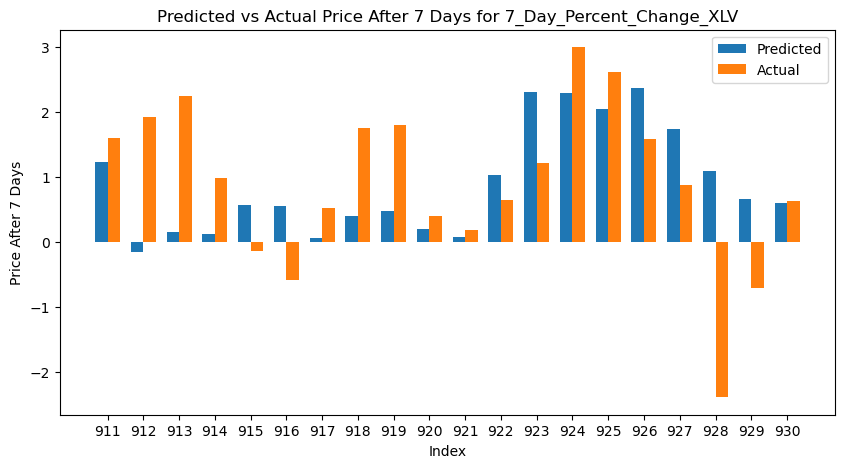

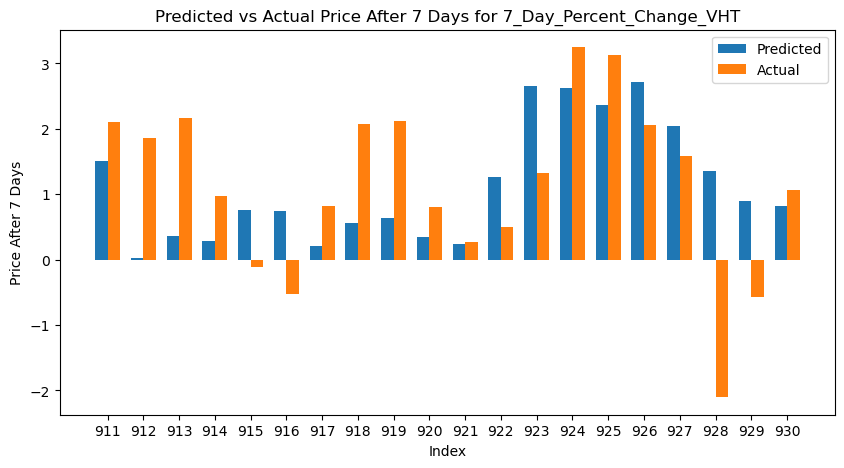

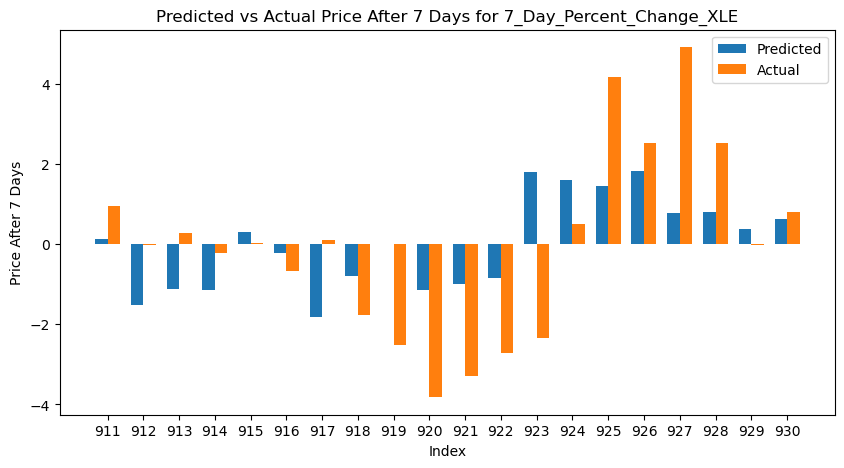

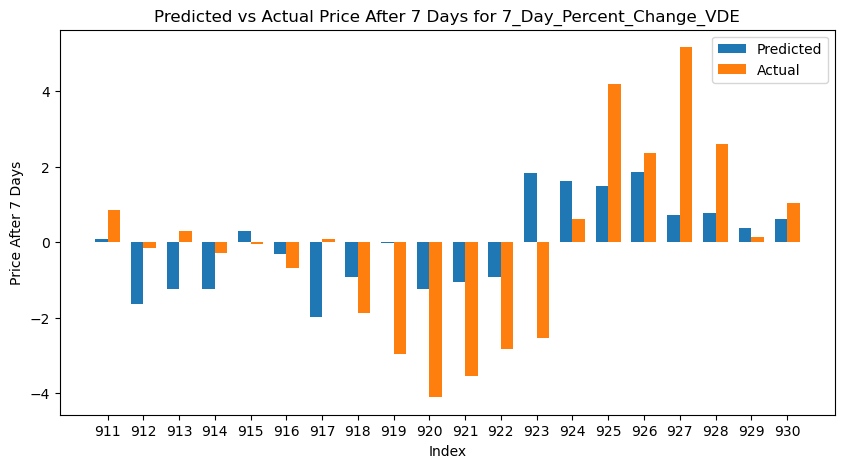

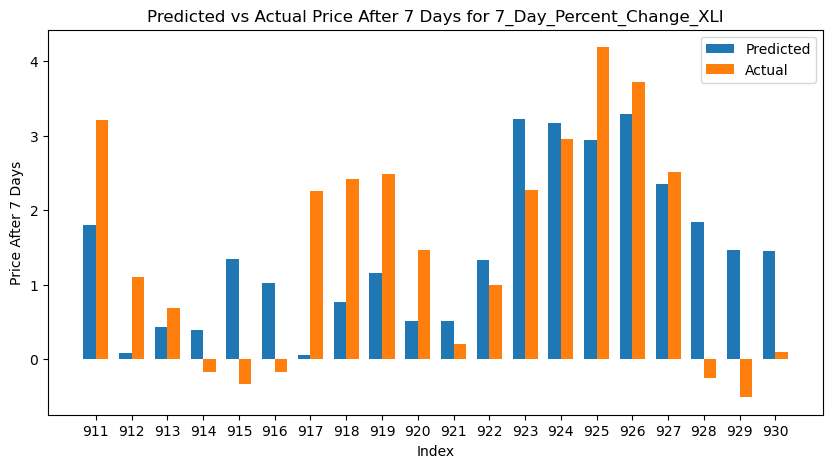

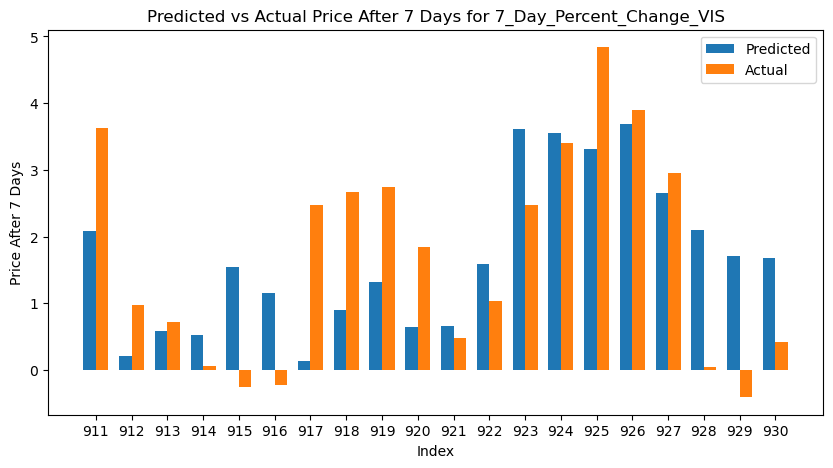

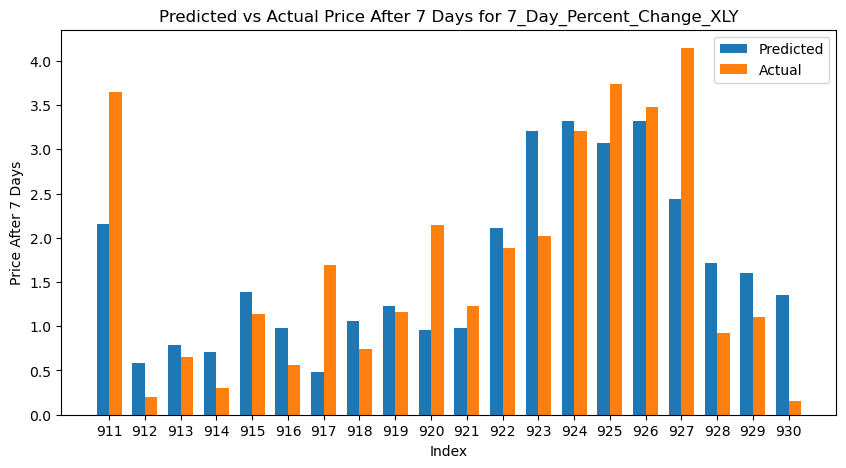

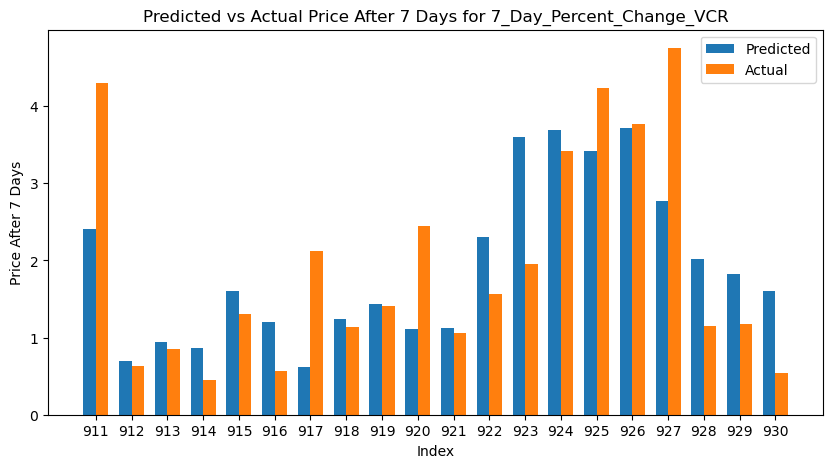

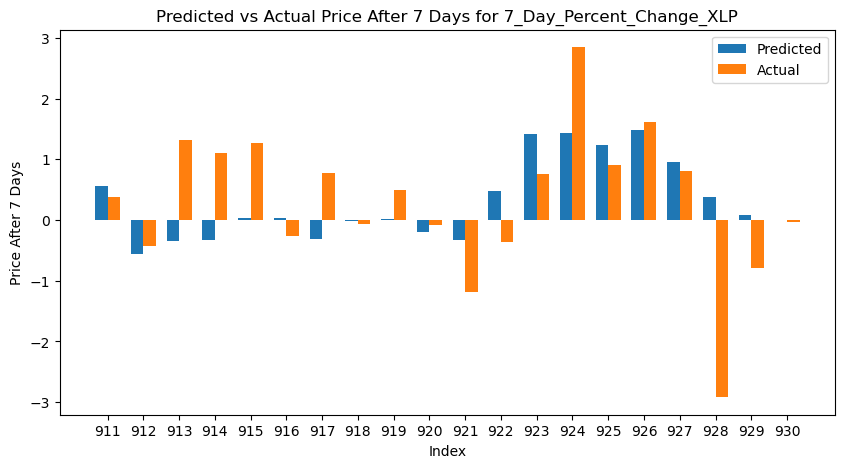

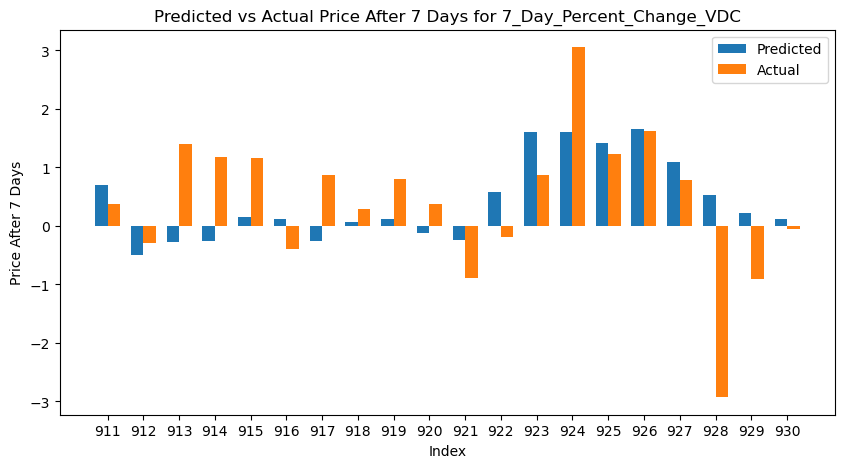

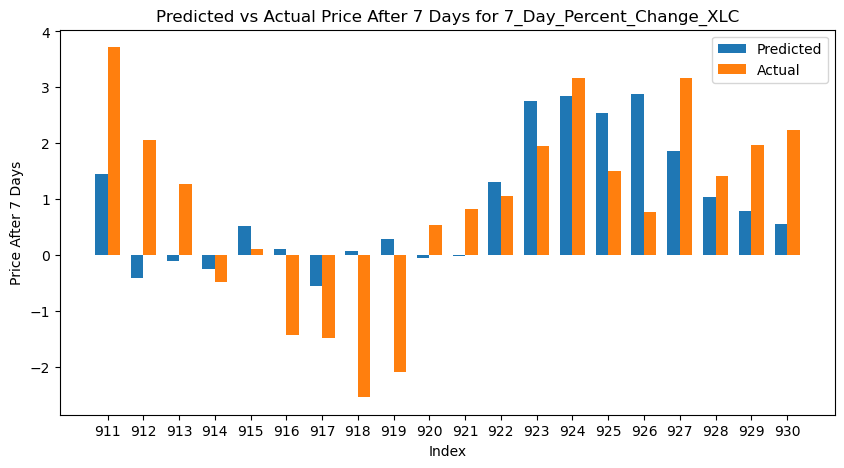

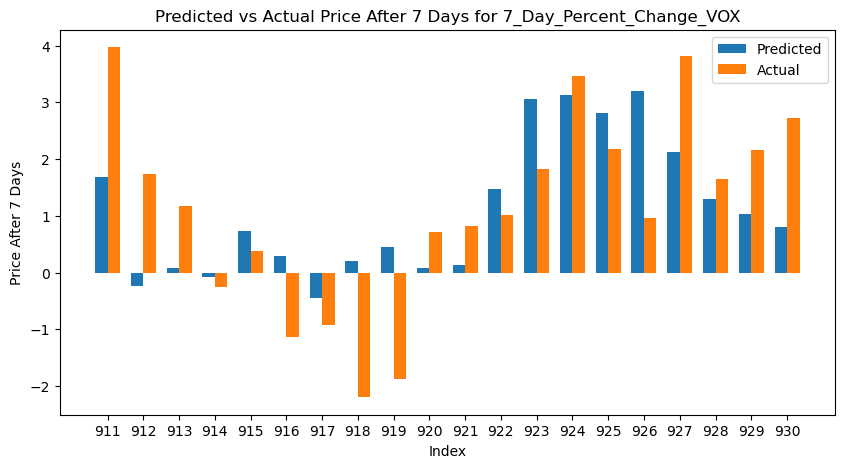

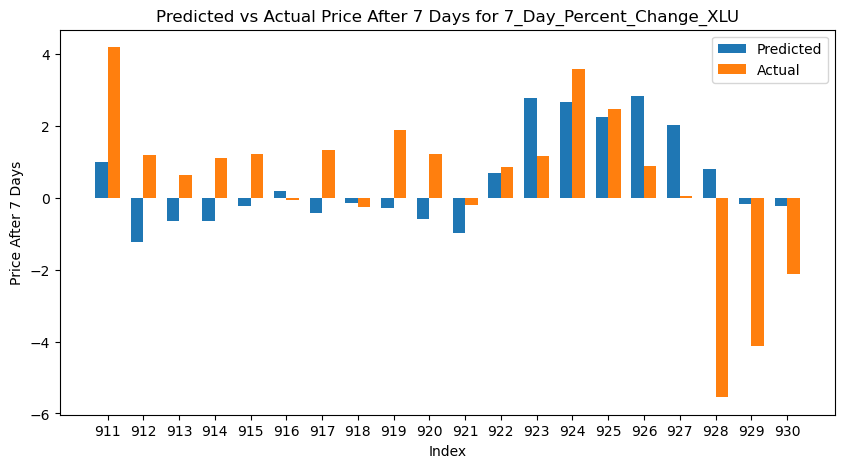

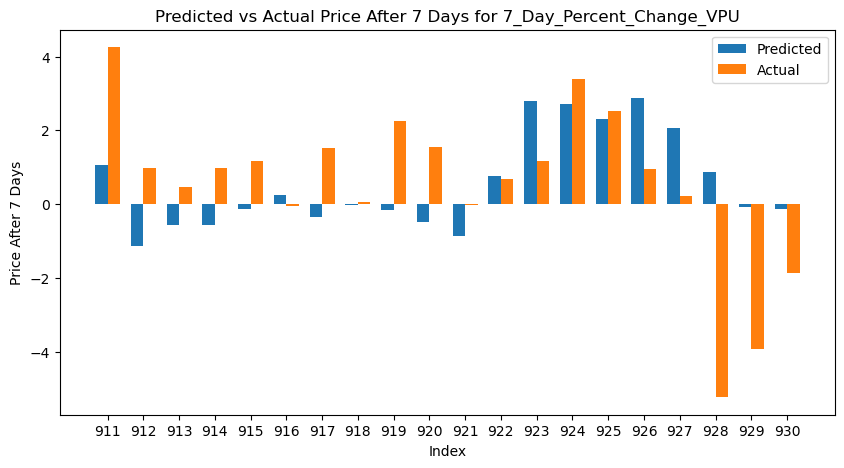

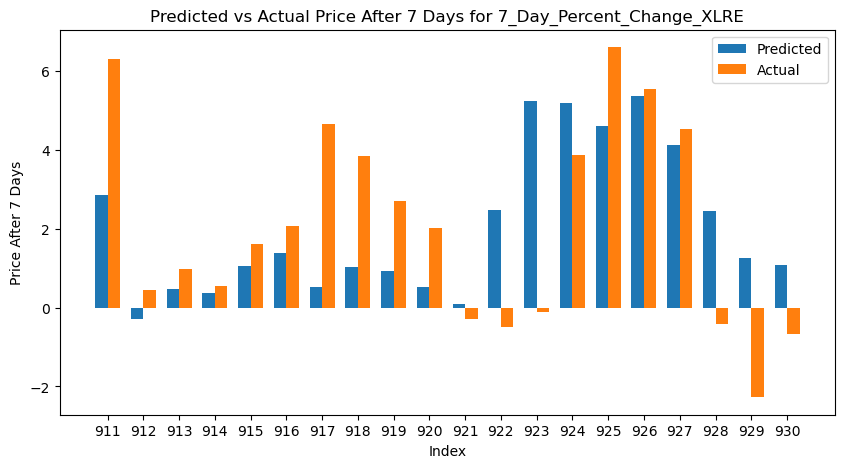

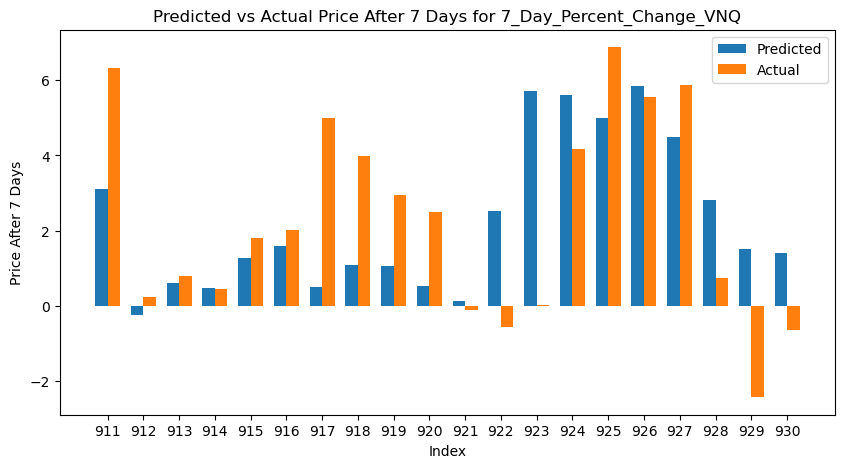

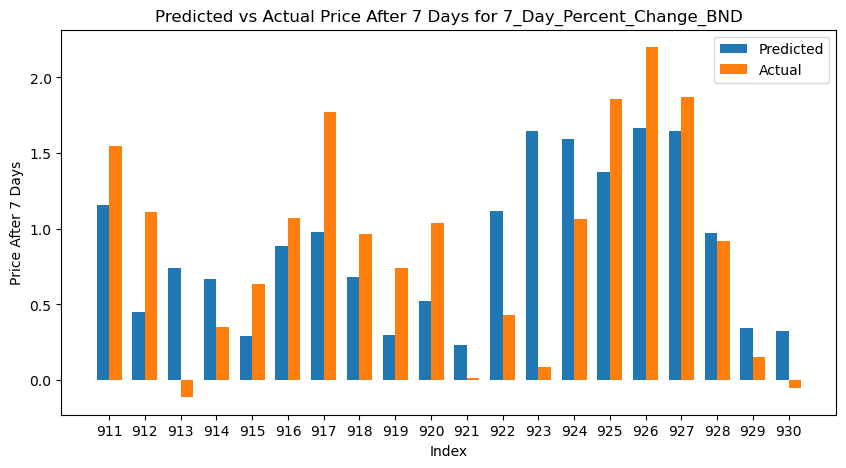

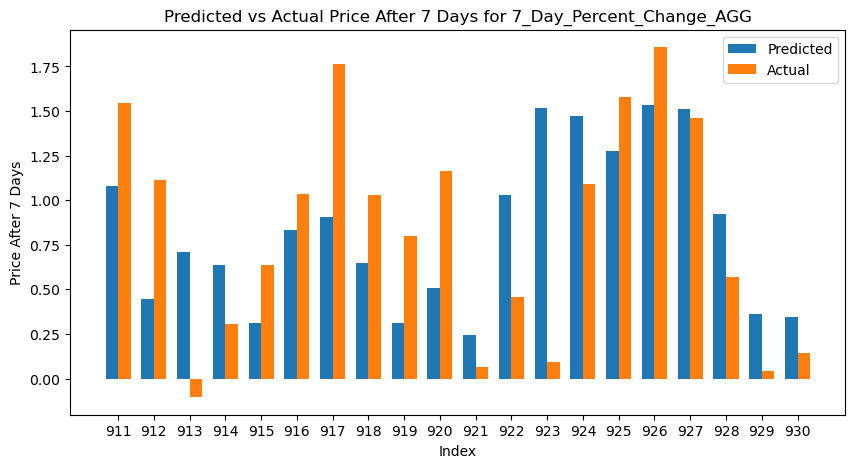

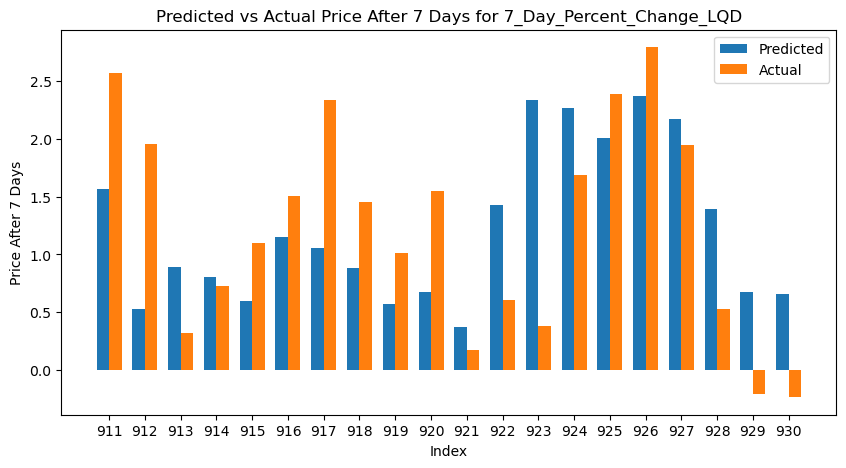

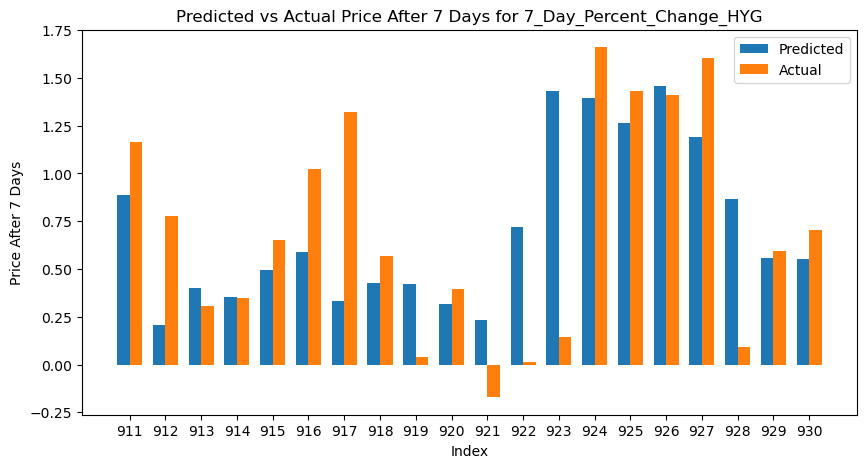

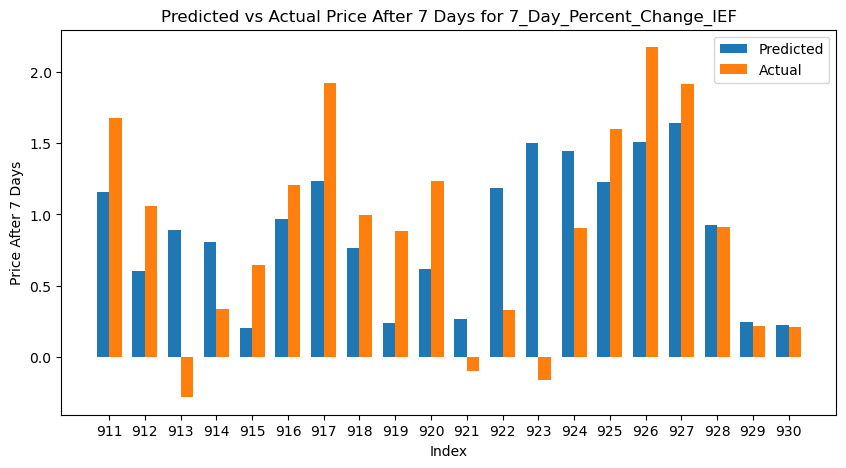

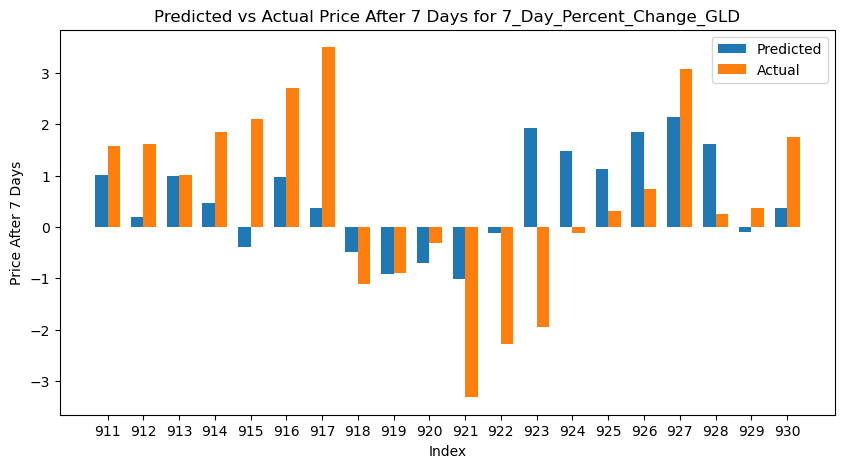

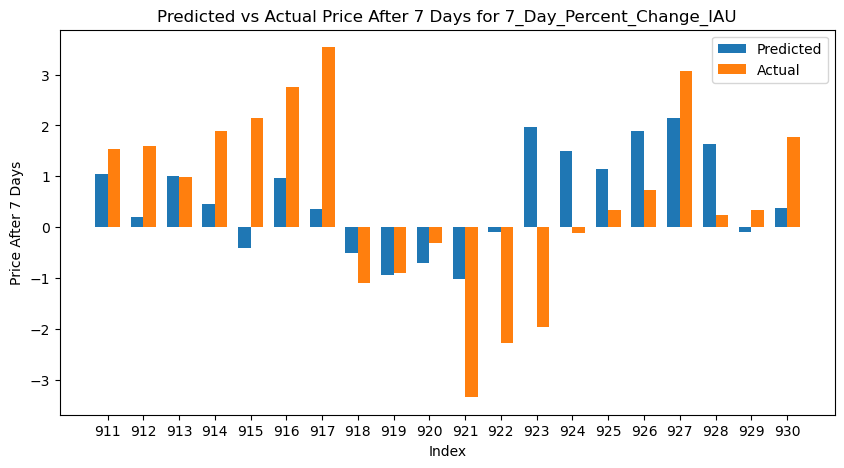

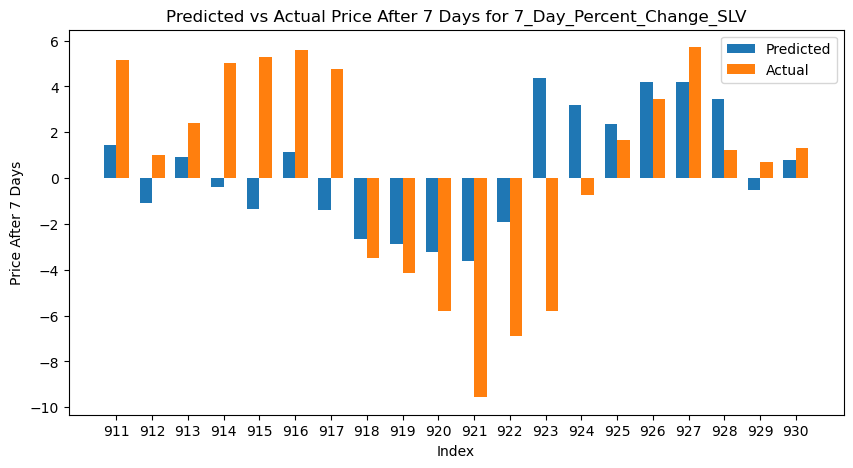

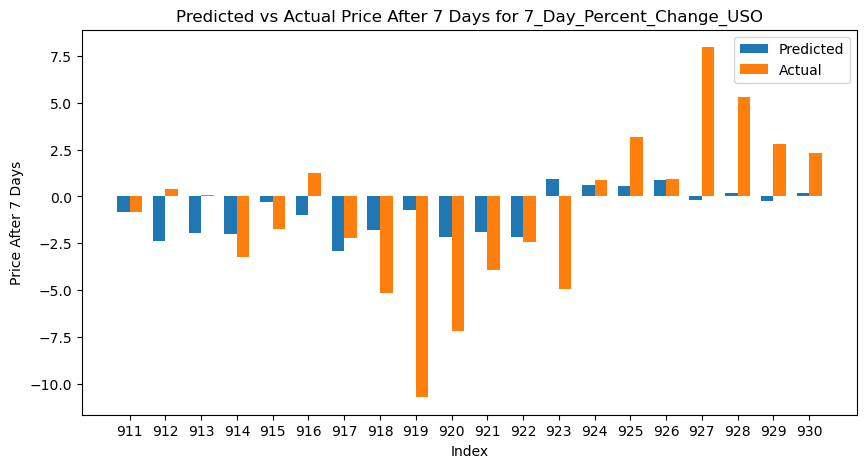

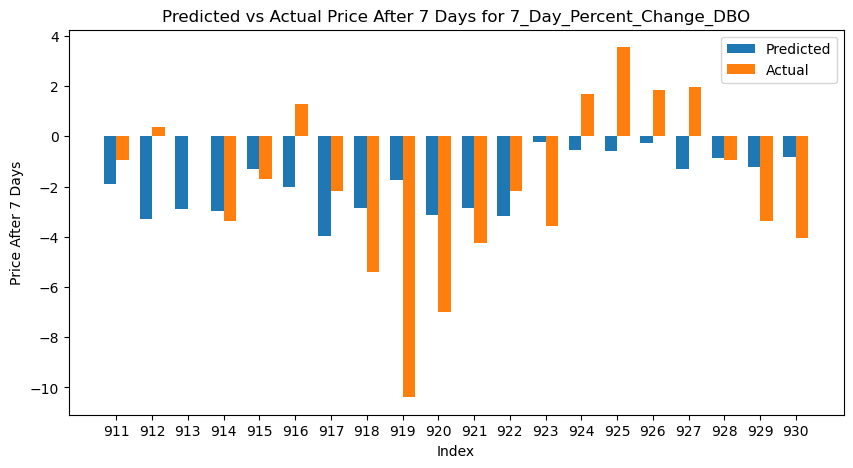

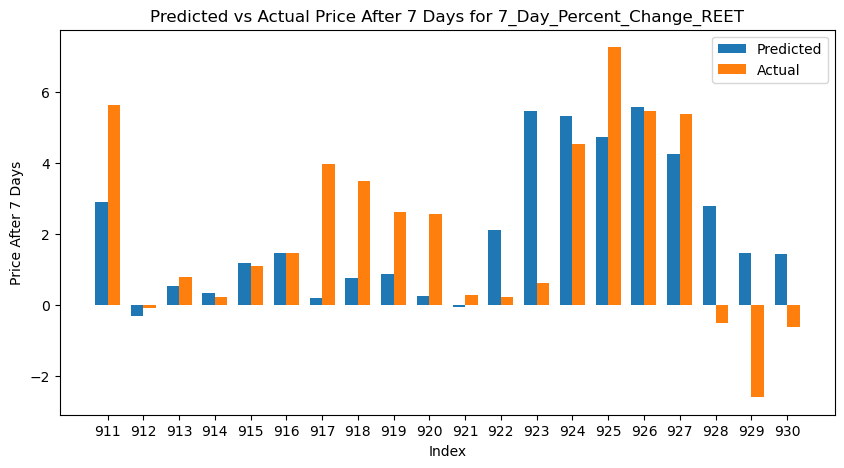

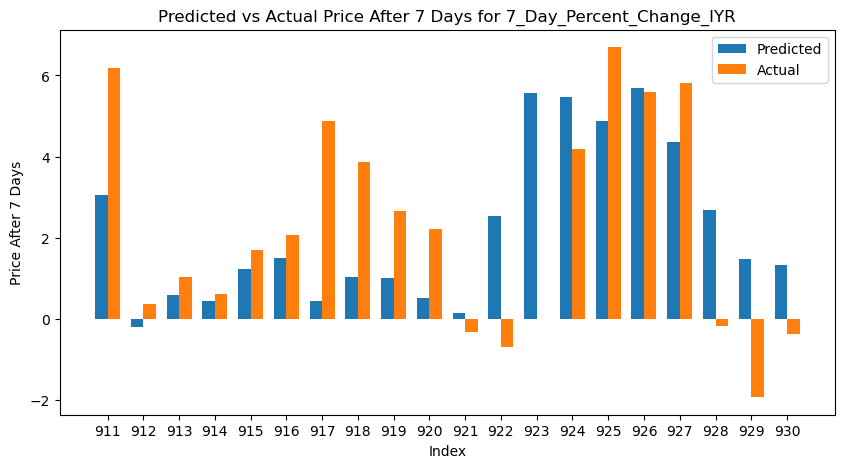

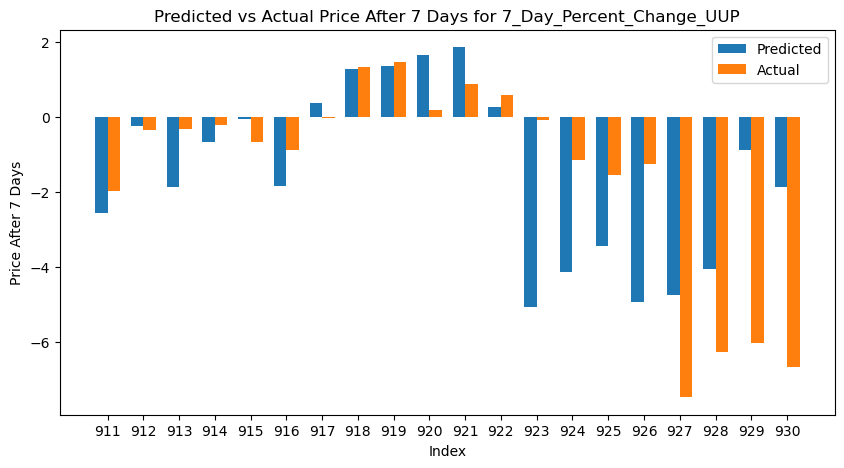

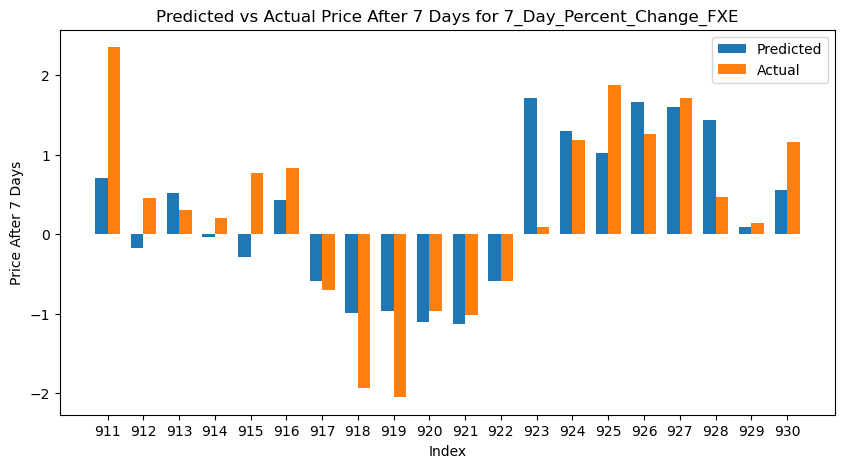

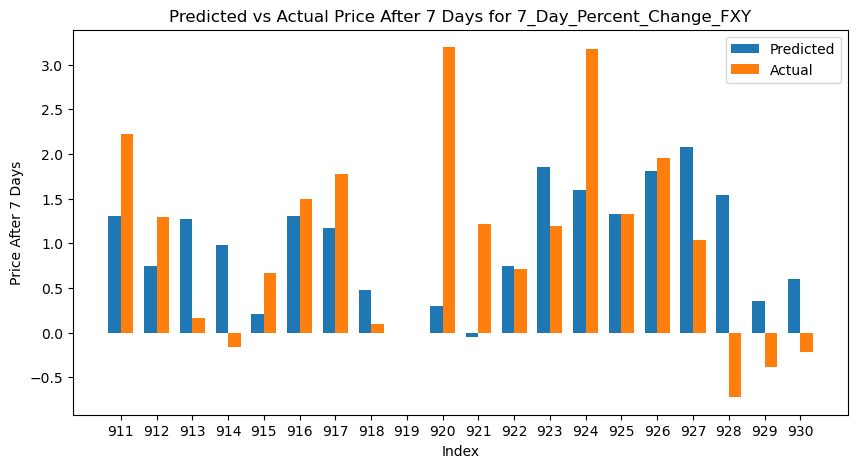

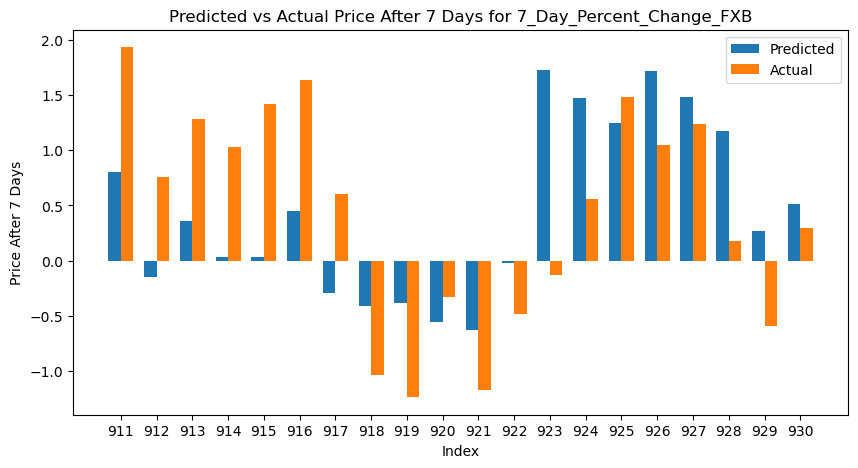

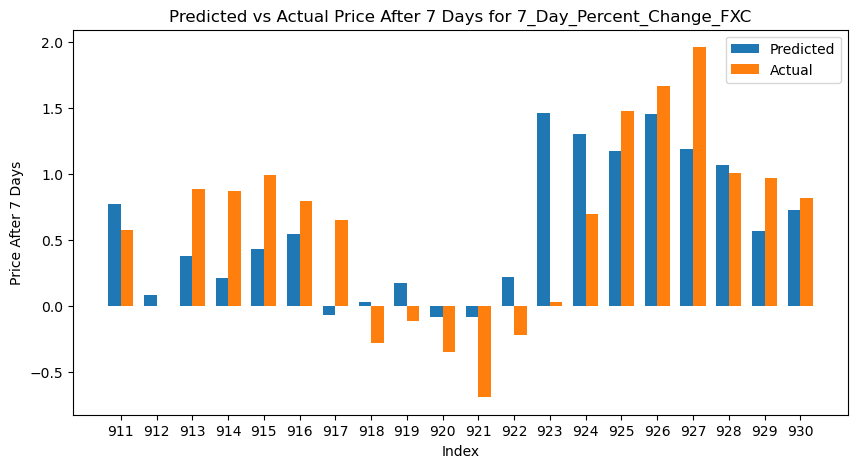

In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the dataset for the new data (yesterday to 7 days ago)
new_data_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/merged_data.csv"
new_data_df = pd.read_csv(new_data_path)

# Get the data from yesterday to 7 days ago
recent_data = new_data_df[-20:]

# Define the input and output columns
input_columns = [col for col in recent_data.columns if '7_day_change' in col or '7_day_volatility' in col]
output_columns = [col for col in recent_data.columns if '7_Day_Percent_Change' in col]

# Drop the date column
recent_data = recent_data.drop(columns=['Date'])

# Split the data into input (X) and output (y)
X_recent = recent_data[input_columns]
y_actual = recent_data[output_columns]

# Standardize the input features using the same scaler used during training
scaler_X = StandardScaler()
X_recent_scaled = scaler_X.fit_transform(X_recent)  # Use fit_transform instead of transform for new scaling

# Load the trained model
model_path = "/Users/stancho/Documents/SogangUniversity/2024spring/Capstone Design & Start-up Artificial Intelligence/model 학습/deep_learning_model.h5"
model = load_model(model_path)

# Make predictions on the recent data
predictions_scaled = model.predict(X_recent_scaled)

# Rescale predictions back to the original scale
scaler_y = StandardScaler()
scaler_y.fit(y_actual)  # Fit the scaler on the actual recent data to match scaling
predictions = scaler_y.inverse_transform(predictions_scaled)

# Plot the comparison of predicted vs actual values for each ETF
for i, column in enumerate(output_columns):
    plt.figure(figsize=(10, 5))
    index = np.arange(len(predictions))
    bar_width = 0.35
    plt.bar(index, predictions[:, i], bar_width, label='Predicted')
    plt.bar(index + bar_width, y_actual.iloc[:, i], bar_width, label='Actual')
    plt.xlabel('Index')
    plt.ylabel('Price After 7 Days')
    plt.title(f'Predicted vs Actual Price After 7 Days for {column}')
    plt.xticks(index + bar_width / 2, recent_data.index)
    plt.legend()
    plt.show()


In [65]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta

# Function to fetch top news headlines from Yahoo Finance for a given date
def fetch_yahoo_finance_news(date):
    url = f"https://finance.yahoo.com/calendar/earnings?day={date}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Adjust the selector based on the actual HTML structure of Yahoo Finance
    headlines = soup.select('h3 a')  # Example selector, adjust as necessary
    news_titles = [headline.get_text().strip() for headline in headlines[:30]]  # Top 30 news titles
    return news_titles

# Create a list of dates for the last 10 years
end_date = datetime.today()
start_date = end_date - timedelta(days=10)
dates = pd.date_range(start=start_date, end=end_date, freq='D').strftime('%Y-%m-%d').tolist()

all_data = []
for date in dates:
    try:
        print(f"Fetching top news for date: {date}")
        news_titles = fetch_yahoo_finance_news(date)
        for title in news_titles:
            all_data.append({'Date': date, 'Title': title})
    except Exception as e:
        print(f"Error fetching news for date {date}: {e}")

# Create a DataFrame from the collected data
if all_data:
    df = pd.DataFrame(all_data)
    print(f"Sample of the data collected:\n{df.head()}")

    # Save the results to a CSV file
    save_path = "./yahoo_finance_top_news_titles_10_years.csv"
    df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")
else:
    print("No data was processed.")

Fetching top news for date: 2024-05-06
Fetching top news for date: 2024-05-07
Fetching top news for date: 2024-05-08
Fetching top news for date: 2024-05-09
Fetching top news for date: 2024-05-10
Fetching top news for date: 2024-05-11
Fetching top news for date: 2024-05-12
Fetching top news for date: 2024-05-13
Fetching top news for date: 2024-05-14
Fetching top news for date: 2024-05-15
Fetching top news for date: 2024-05-16
Sample of the data collected:
         Date          Title
0  2024-05-06           News
1  2024-05-06           Life
2  2024-05-06  Entertainment
3  2024-05-06        Finance
4  2024-05-06         Sports
Results saved to ./yahoo_finance_top_news_titles_10_years.csv


In [72]:
import requests
import pandas as pd
from datetime import datetime, timedelta

API_KEY = '4aeec77f6d1c49f1890a92eca159d4b5'
BASE_URL = 'https://newsapi.org/v2/everything'

def fetch_articles(api_key, start_date, end_date):
    all_articles = []
    url = BASE_URL
    params = {
        'domains': 'wsj.com',
        'apiKey': api_key,
        'from': start_date,
        'to': end_date,
        'pageSize': 100,
        'page': 1,
        'sortBy': 'publishedAt'
    }
    
    while True:
        response = requests.get(url, params=params)
        data = response.json()
        
        if data.get('status') != 'ok':
            print(f"Error fetching articles: {data.get('message')}")
            break
        
        articles = data.get('articles', [])
        all_articles.extend(articles)
        
        if len(articles) < 100:
            break
        
        params['page'] += 1
        
        if params['page'] > 5:  # To avoid too many requests in one go
            break

    return all_articles

def collect_data(api_key, years=10):
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=365 * years)
    date_ranges = pd.date_range(start=start_date, end=end_date, freq='M')
    
    all_data = []
    
    for i in range(len(date_ranges) - 1):
        start = date_ranges[i].strftime('%Y-%m-%d')
        end = date_ranges[i + 1].strftime('%Y-%m-%d')
        
        print(f"Fetching articles from {start} to {end}")
        articles = fetch_articles(api_key, start, end)
        
        for article in articles:
            published_at = article.get('publishedAt')
            title = article.get('title')
            if published_at and title:
                date = published_at.split('T')[0]
                all_data.append({'Date': date, 'Title': title})
    
    return all_data

def main():
    all_data = collect_data(API_KEY, years=10)
    
    if all_data:
        df = pd.DataFrame(all_data)
        print(f"Sample of the data collected:\n{df.head()}")
        save_path = "./wsj_top_news_titles_10_years.csv"
        df.to_csv(save_path, index=False)
        print(f"Results saved to {save_path}")
    else:
        print("No data was processed.")

if __name__ == "__main__":
    main()

Fetching articles from 2014-05-31 to 2014-06-30
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2014-05-31. You may need to upgrade to a paid plan.
Fetching articles from 2014-06-30 to 2014-07-31
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2014-06-30. You may need to upgrade to a paid plan.
Fetching articles from 2014-07-31 to 2014-08-31
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2014-07-31. You may need to upgrade to a paid plan.
Fetching articles from 2014-08-31 to 2014-09-30
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as

Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2016-11-30. You may need to upgrade to a paid plan.
Fetching articles from 2016-12-31 to 2017-01-31
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2016-12-31. You may need to upgrade to a paid plan.
Fetching articles from 2017-01-31 to 2017-02-28
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2017-01-31. You may need to upgrade to a paid plan.
Fetching articles from 2017-02-28 to 2017-03-31
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2017-02-28. 

Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2019-06-30. You may need to upgrade to a paid plan.
Fetching articles from 2019-07-31 to 2019-08-31
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2019-07-31. You may need to upgrade to a paid plan.
Fetching articles from 2019-08-31 to 2019-09-30
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2019-08-31. You may need to upgrade to a paid plan.
Fetching articles from 2019-09-30 to 2019-10-31
Error fetching articles: You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-04-15, but you have requested 2019-09-30. 

Error fetching articles: You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.
Fetching articles from 2022-01-31 to 2022-02-28
Error fetching articles: You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.
Fetching articles from 2022-02-28 to 2022-03-31
Error fetching articles: You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.
Fetching articles from 2022-03-31 to 2022-04-30
Error fetching articles: You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests availabl